In [1]:
%reload_ext autoreload
%autoreload 2


%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt

import scienceplots
#change the default matplotlib style sheet
matplotlib.style.use("science")

import jax.numpy as jnp
import jax

from pophod import zheng2007


In [2]:
def plot_hod_model(ax, fig, Mhs, centrals, satellites, totals):
    ax.plot(Mhs, centrals, label='centrals', lw = 2)
    ax.plot(Mhs, satellites, label='satellites', lw = 2)
    ax.loglog(Mhs, totals, label='totals', lw = 2)
    ax.set_xlabel(r'$M_h [M_{\odot}]$')
    ax.set_ylabel(r'$\langle N(M_h) \rangle$')
    ax.legend()
    ax.set_xlim(5e11, 1e15)
    fig.tight_layout()
    return None

In [3]:
#seed for the random number generator
seed = 0

#just regulates mass threshod for satellites, turn it off
kappa = 0.

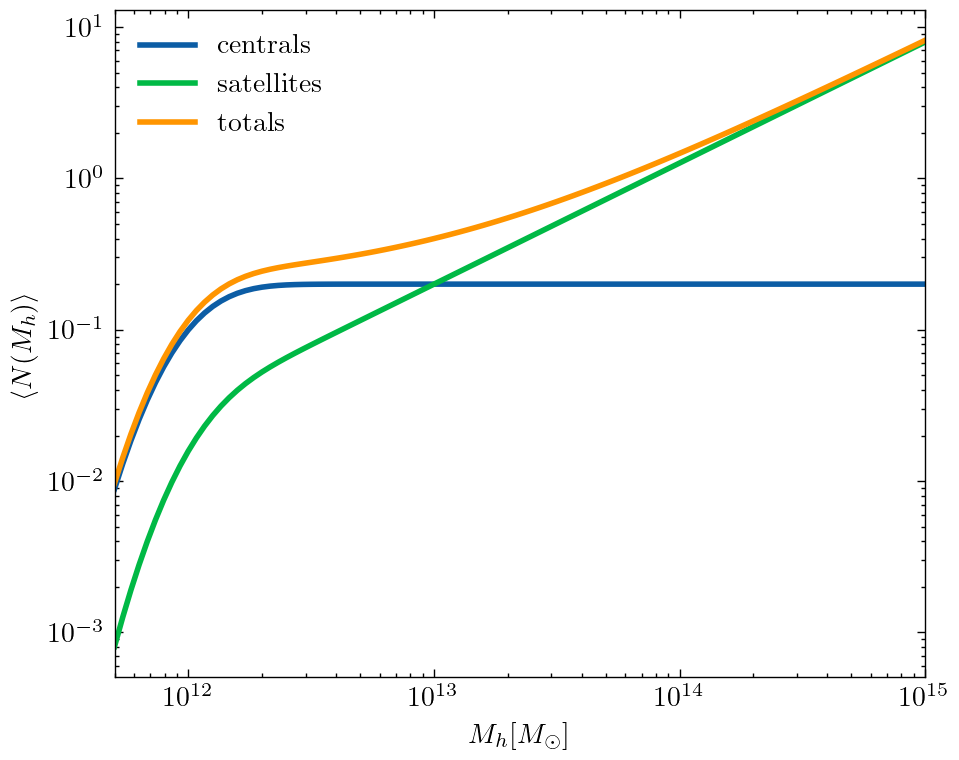

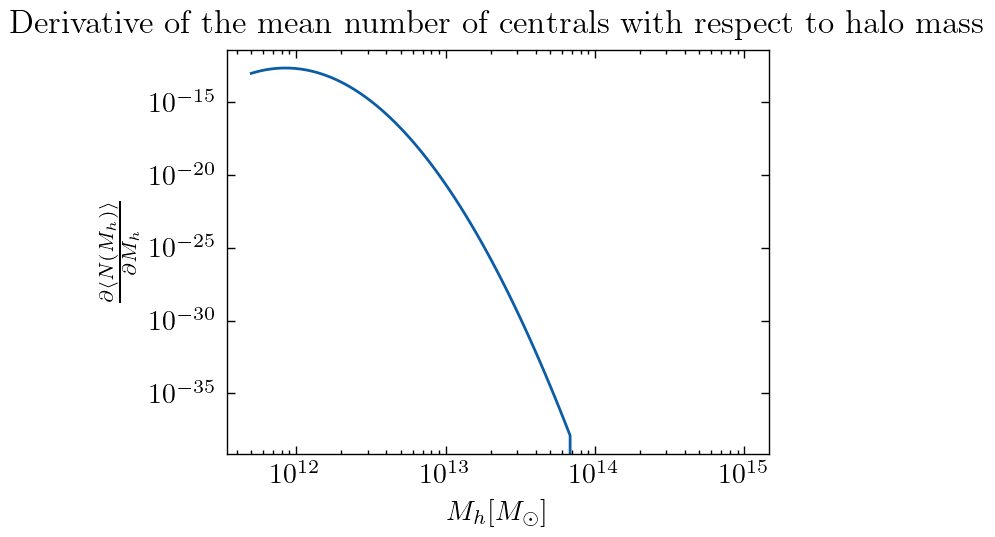

In [4]:
### Values of Figure 1 from https://arxiv.org/pdf/2106.08438.pdf
Fig1HodProps = {'seed': seed,
 'kappa': kappa,
 'log10Mmin': 12,
 'log10M1': 13,
 'alpha': 0.8,
 'sigma_logM': 0.25,
 'fcen': 0.2}

Zheng2007 = zheng2007.Zheng2007(**Fig1HodProps)

Mhs = jnp.logspace(jnp.log10(5e11), 15, 100)
centrals, satellites, totals = Zheng2007(Mhs)

fig, ax = plt.subplots(1, 1, figsize = (5, 4))
plot_hod_model(ax, fig, Mhs, centrals, satellites, totals)
plt.show()

#Can also plots derivates

plt.title("Derivative of the mean number of centrals with respect to halo mass")
plt.loglog(Mhs, jax.vmap(jax.grad(Zheng2007.mean_centrals))(Mhs))
plt.xlabel(r'$M_h [M_{\odot}]$')
plt.ylabel(r'$\frac{\partial\langle N(M_h) \rangle}{\partial M_h}$')
plt.show()

In [5]:
### Values from https://arxiv.org/pdf/2106.08438.pdf
 
MaglimHodProps = {}
MaglimHodProps[0] = {'log10Mmin': 11.75, 'log10M1': 13.36, 'alpha': 1.7, 'sigma_logM': 0.28, "fcen": 1.0}
MaglimHodProps[1] = {'log10Mmin': 11.93, 'log10M1': 13.43, 'alpha': 1.83, 'sigma_logM': 0.26, "fcen": 1.0}
MaglimHodProps[2] = {'log10Mmin': 11.88, 'log10M1': 12.84, 'alpha': 1.24, 'sigma_logM': 0.21, "fcen": 1.0}
MaglimHodProps[3] = {'log10Mmin': 11.82, 'log10M1': 13.44, 'alpha': 2.29, 'sigma_logM': 0.31, "fcen": 1.0}

a_values = [0.41, 0.63, 1.21, 1.19]

for M in MaglimHodProps:
    MaglimHodProps[M]['kappa'] = kappa
    MaglimHodProps[M]['seed'] = seed

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_12837/1818273398.py:9: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


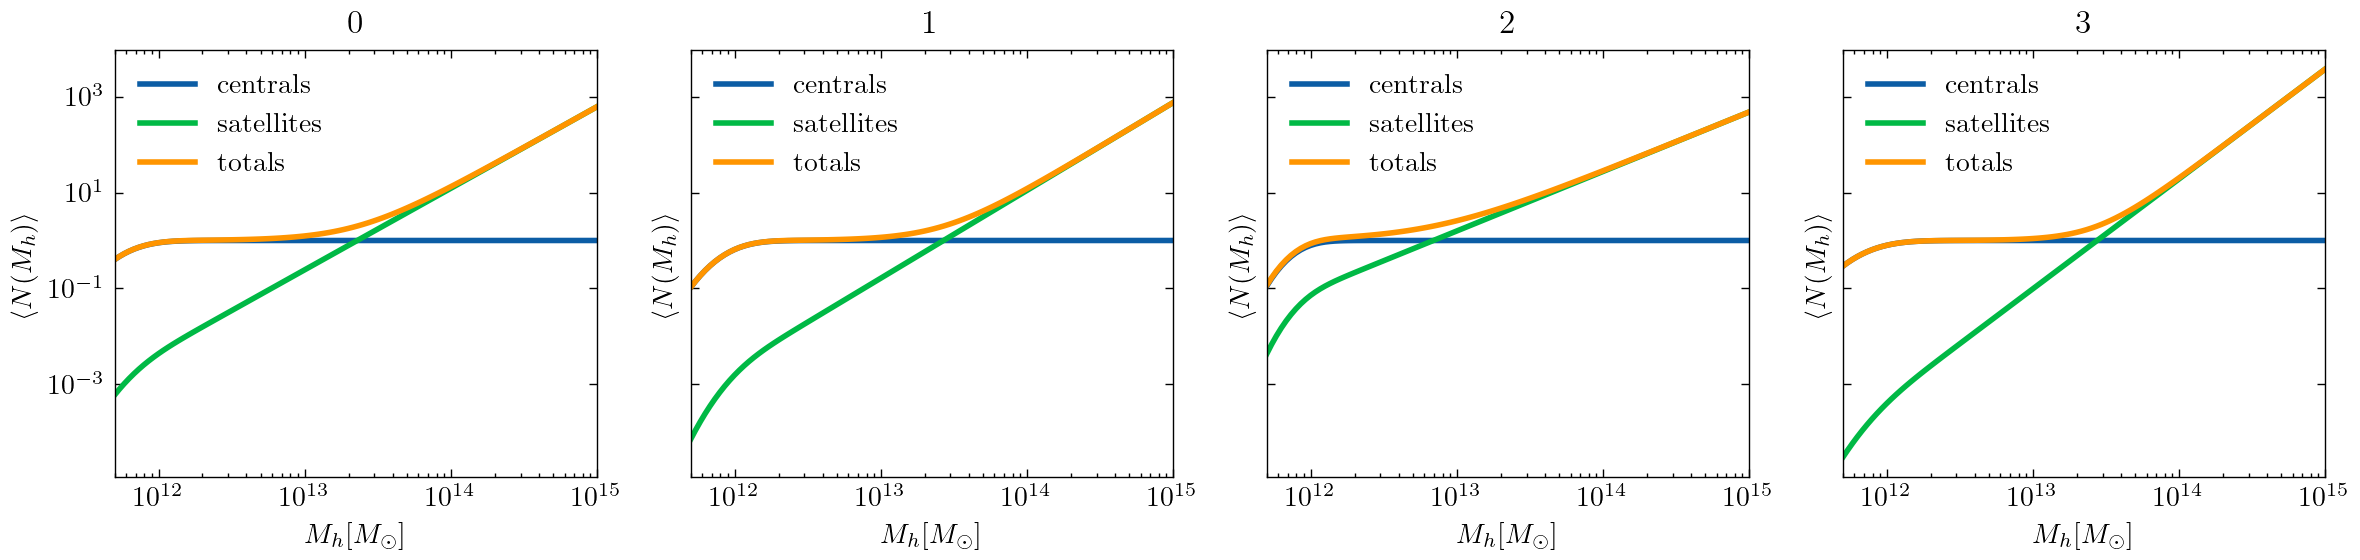

In [6]:
## Let's now plot the HODs for the different magnitude bins

Mhs = jnp.logspace(jnp.log10(5e11), 15, 100)

fig, axs = plt.subplots(1, 4, figsize = (12, 3), sharey = True)
for i in range(4):
    index = i
    Zheng = zheng2007.Zheng2007(**MaglimHodProps[index])
    centrals, satellites, totals = Zheng(Mhs)
    plot_hod_model(axs[i], fig, Mhs, centrals, satellites, totals)
    axs[i].set_title(index)
plt.show()


### Let's make a mock population

In [7]:
from pophod import hod

HOD = hod.HOD(seed = 0)

index = 0
Zheng = zheng2007.Zheng2007(**MaglimHodProps[index])

centrals, satellites, totals = Zheng(Mhs)

In [8]:
central_galaxies = HOD.centrals(centrals) #which galaxies are centrals
satellite_galaxies = HOD.satellites(satellites) #which galaxies are satellites

## Load Websky Masses

Now that we know how things work, we use directly the Websky catalog.

In [9]:
import pathlib
import numpy as np

def read_z_nz(zbin):
    return np.loadtxt(nzs_dir/nzs_file(zbin), unpack = True)  


redshift_bins = [0.20, 0.40, 0.55, 0.70, 0.85, 0.95, 1.05]

Ngals = [2236462, 1599487, 1627408, 2175171, 1583679, 1494243]

nzs_dir = pathlib.Path('/Users/omard/Documents/projects/actxdes/pipeline/measure/explore/output/')
nzs_file = lambda zbin: f'galaxy_z_nz_{zbin[0]}-{zbin[1]}.txt'


zbin = index

Ngal = Ngals[zbin]

zbin_ = (redshift_bins[zbin], redshift_bins[zbin+1])
z, nzfull = read_z_nz(zbin_)
nz = nzfull/jnp.trapz(nzfull, z)

eps = 0.2
zmin, zmax = redshift_bins[zbin]-eps, redshift_bins[zbin+1]+eps

#Ωm =0.31, ΩΛ = 0.69, Ωb = 0.049, h = 0.68, σ8 = 0.81, and ns = 0.965, 

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_12837/1055244770.py:22: DeprecationWarning: jax.numpy.trapz is deprecated. Use jax.scipy.integrate.trapezoid instead.
  nz = nzfull/jnp.trapz(nzfull, z)


In [10]:
from pophod.utils import websky

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [11]:
direc = '/Users/omard/Downloads/ACTXDES-DATA/Websky Sims'
directory = pathlib.Path(direc)

websky_halo_catalog_name = 'halos.pksc'


W = websky.WebSky(directory_path = direc, websky_version = "")
Nmax = None
Nmax = 5e8

try:
    matrix = np.load(f"matrix_{zbin}.npy")
except:
    print("Loading full halo catalogue")
    matrix = W.load_halo_catalogue(zmin = zmin, zmax = zmax, Nmax = Nmax)
    np.save(f"matrix_{zbin}.npy", matrix)

position, velocity, mass, redshift = matrix[:, 0:3], matrix[:, 3:6], matrix[:, 6], matrix[:, 7]

Nhalos = position.shape[0]
print(f"Nhalos = {Nhalos}")

Nhalos = 46027224


In [12]:
zmin_maglim, zmax_maglim = 0., 1.
massmin_maglim, massmax_maglim = 1e10, 1e15

selection = (redshift > zmin_maglim) & (redshift < zmax_maglim) & (mass > massmin_maglim) & (mass < massmax_maglim)

In [13]:
position_selected = position[selection]
velocity_selected = velocity[selection]
mass_selected = mass[selection]
redshift_selected = redshift[selection]

In [14]:
from pophod import hod

HOD = hod.HOD(seed = seed)

cdm = 7. #assumed concentration for dm

rho_m0 = 2.775e11 * W.websky_cosmo['Omega_M'] * W.websky_cosmo['h']**2
rho_mz = rho_m0 * jnp.power(1+redshift_selected, 3)
R = jnp.power(3*mass_selected/(4*jnp.pi*200*rho_mz), 1/3) # Mpc

In [15]:
centrals, satellites, totals = Zheng(mass_selected)

In [18]:
central_galaxies_sel = HOD.centrals(centrals) #which galaxies are centrals
satellite_galaxies_sel = HOD.satellites(satellites) #which galaxies are satellites

In [19]:
central_galaxies_sel = central_galaxies_sel.astype(bool)

In [20]:
position_selected = position_selected[central_galaxies_sel]
velocity_selected = velocity_selected[central_galaxies_sel]
mass_selected = mass_selected[central_galaxies_sel]
redshift_selected = redshift_selected[central_galaxies_sel]
R = R[central_galaxies_sel]
satellite_galaxies_sel = satellite_galaxies_sel[central_galaxies_sel]
central_galaxies_sel = central_galaxies_sel[central_galaxies_sel]

In [21]:
#now select the satellites
satellite_galaxies_sel_bool = satellite_galaxies_sel.astype(bool)
position_selected_sat = position_selected[satellite_galaxies_sel_bool]
velocity_selected_sat = velocity_selected[satellite_galaxies_sel_bool]
mass_selected_sat = mass_selected[satellite_galaxies_sel_bool]
redshift_selected_sat = redshift_selected[satellite_galaxies_sel_bool]
R_sat = R[satellite_galaxies_sel_bool]

In [22]:
satellite_galaxies = satellite_galaxies_sel[satellite_galaxies_sel_bool]

In [23]:
conc = 7.85 * jnp.power(mass_selected_sat/(2e12/W.websky_cosmo["h"]), -0.081) / \
            jnp.power(1+redshift_selected_sat, 0.71)

conc = 3 * jnp.power(mass_selected_sat/(2e12/W.websky_cosmo["h"]), -0.081) / \
            jnp.power(1+redshift_selected_sat, 0.71)

In [24]:
central_position_for_sat = jnp.repeat(position_selected_sat, satellite_galaxies, axis = 0)
R_for_sat = jnp.repeat(R_sat, satellite_galaxies, axis = 0)
conc_for_sat = jnp.repeat(conc, satellite_galaxies, axis = 0)

In [25]:
satellite_positions = HOD.sat_positions(central_position_for_sat, R_for_sat, concentration = conc_for_sat*a_values[index]*np.ones_like(R_for_sat))

In [26]:
del central_position_for_sat
del R_for_sat

In [27]:
gal_catalog = jnp.concatenate([position_selected_sat, satellite_positions], axis = 0)

In [28]:
import pyccl as ccl
import pyccl.nl_pt as pt
cosmodict = W.websky_cosmo
Omegam, Omegab, h, ns = cosmodict["Omega_M"], cosmodict["Omega_B"], cosmodict["h"], cosmodict["n_s"]
As = 2.0219683908526204e-09
Omegac = Omegam-Omegab
cosmo = ccl.Cosmology(Omega_c=Omegac, Omega_b=Omegab, h=h, A_s=As, n_s=ns)

In [29]:
chi = np.sqrt(np.sum(gal_catalog**2., axis = 1))#Mpc
redshift_catalog = 1/cosmo.scale_factor_of_chi(chi)-1

In [31]:
nside = 1024
mappa = websky.catalogue_to_map(gal_catalog, nside = nside)

In [32]:
mappa_centrals = websky.catalogue_to_map(position_selected_sat, nside = nside)

In [33]:
redshift_centrals = 1/cosmo.scale_factor_of_chi(np.sqrt(np.sum(position_selected_sat**2., axis = 1)))-1

In [34]:
import healpy as hp
from plancklens import shts

Using lenspyx alm2map


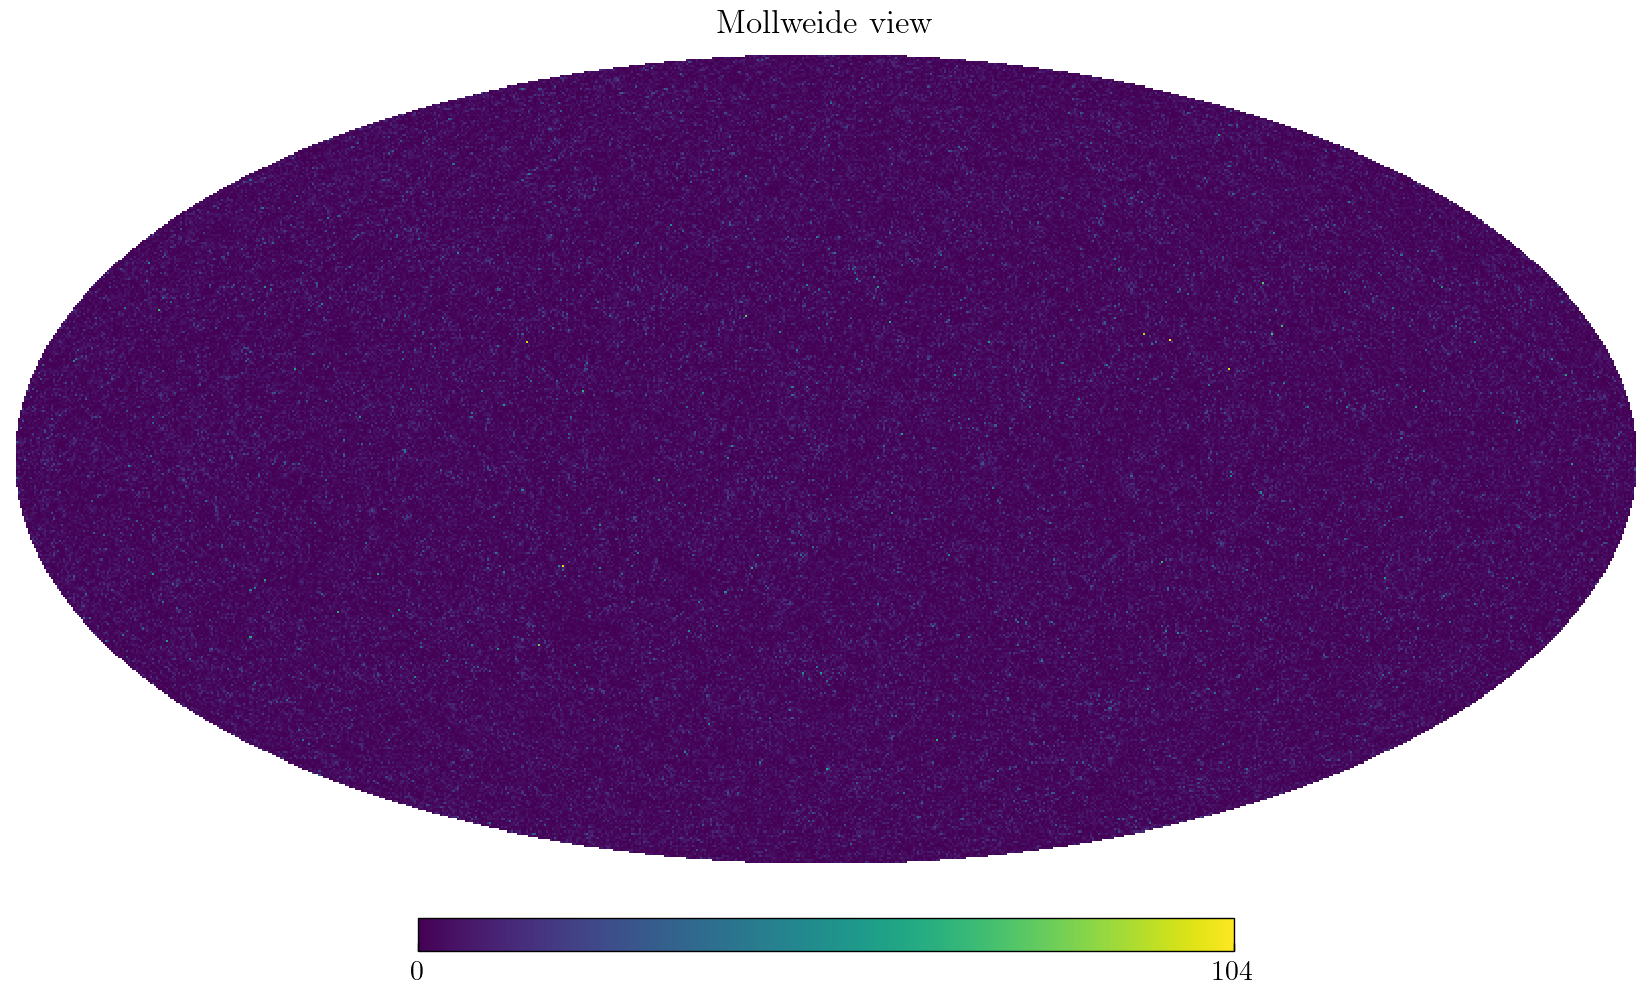

In [35]:
hp.mollview(mappa)

In [36]:
delta = mappa/mappa.mean()-1
delta_centrals = mappa_centrals/mappa_centrals.mean()-1

In [37]:
alms = shts.map2alm(delta.copy(), lmax = 3*nside-1)
alms_centrals = shts.map2alm(delta_centrals.copy(), lmax = 3*nside-1)

In [38]:
nobjects = mappa.sum()
nobjects_centrals = mappa_centrals.sum()

area = 4*np.pi

shot_noise = nobjects/area
shot_noise_centrals = nobjects_centrals/area

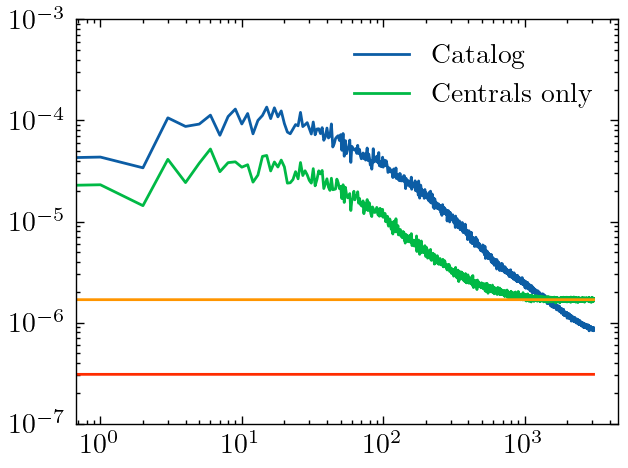

In [39]:
ls = np.arange(3*nside)
plt.loglog(ls, hp.alm2cl(alms), label = "Catalog")

plt.loglog(ls, hp.alm2cl(alms_centrals), label = "Centrals only")

plt.loglog(ls, 1/shot_noise_centrals*np.ones_like(ls))

plt.loglog(ls, 1/shot_noise*np.ones_like(ls))

plt.ylim(1e-7, 1e-3)

plt.legend()

## Compare with MICE

In [269]:
def reweight_halos2(input_positions: np.ndarray, input_redshifts: np.ndarray, Ngals: int, outz: np.ndarray, outnz: np.ndarray, zmin: float, zmax: float, Nslices: int = 30):

    #zmin, zmax = outz.min(), outz.max()
    z_bins = np.linspace(zmin, zmax, Nslices + 1)
    nz_bins = np.interp(z_bins, outz, outnz)
    norm = np.trapz(nz_bins, z_bins)
    nz_bins = nz_bins/norm

    weights = np.array([0.5*(nz_bins[i + 1] + nz_bins[i]) * (z_bins[i + 1] - z_bins[i]) for i in range(len(nz_bins) - 1)])

    weights = weights*Ngals
    weights = weights.astype(int)

    indices = np.searchsorted(z_bins, input_redshifts, side = 'left')-1

    ids = []
    Ntot = 0
    for i in range(len(z_bins)-1):
        z_sel = np.where(indices == i)[0]
        if len(z_sel) > 0:
            sample = np.random.choice(z_sel, weights[i], replace = False)
            ids.append(sample)
            Ntot += len(sample)

    ids = np.concatenate(ids)

    new_zs = input_redshifts[ids]
    new_position = input_positions[ids]

    return new_zs, new_position


In [270]:
path_mice = pathlib.Path("/Users/omard/Downloads/ACTXDES-DATA/MICE SIMULATION/")
i = index
z_cent, hist = np.loadtxt(path_mice/f"dn_dz_mice_{i}.txt").T
hist = hist/np.trapz(hist, z_cent)
ells, ggcounts, kgcounts, nshot_nmt = np.loadtxt(path_mice/f"mice_gg_{i}.txt").T

In [271]:
NN = Ngals[index]
NN = 2934809.0
#new_zs, new_position = reweight_halos2(position_selected_sat, redshift_centrals, NN, z_cent, hist, redshift_catalog.min(), redshift_catalog.max())
new_zs, new_position = reweight_halos2(gal_catalog, redshift_catalog, NN, z_cent, hist, redshift_catalog.min(), redshift_catalog.max())
counts = websky.catalogue_to_map(new_position, nside = nside)

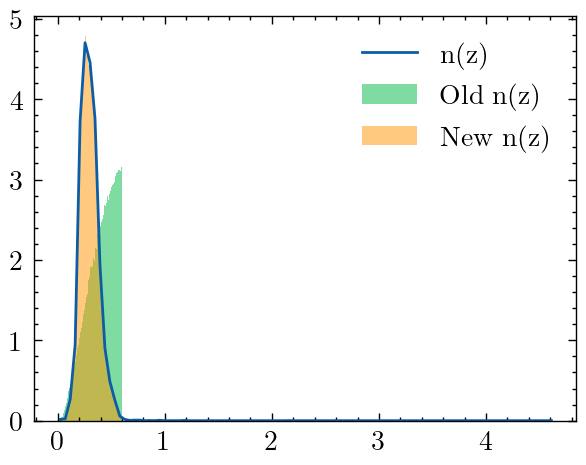

In [272]:
plt.plot(z_cent, hist, label = 'n(z)')
plt.hist(redshift_catalog, bins = 100, density = True, alpha = 0.5, label = 'Old n(z)')
plt.hist(new_zs, density = True, bins = 100, label = 'New n(z)', alpha = 0.5)
plt.legend()
plt.show()

In [273]:
counts.sum()/2934809.0

0.9999952296725272

In [274]:
delta_counts = counts/counts.mean()-1
alm_counts = shts.map2alm(delta_counts.copy(), lmax = 3*nside-1)

In [275]:
kappa_name = directory/'kap.fits'
kappa_ = hp.read_map(kappa_name)
kappa_websky = hp.pixelfunc.ud_grade(kappa_, nside)
kappa_websky_alm = hp.map2alm(kappa_websky.copy(), lmax = 3*nside-1)

In [276]:
kappa_mice = hp.read_map(path_mice/'MICE_kappaMap_kcmbmappy.N4096L3072.n8192.step0_degrade.n2048.fits')
kappa_mice_alm = hp.map2alm(kappa_mice.copy(), lmax = 3*nside-1)

In [277]:
counts_mice = hp.read_map(path_mice/f"mice_counts_{i}.fits", verbose = False)
delta_mice = counts_mice/counts_mice.mean()-1
alm_mice = shts.map2alm(delta_mice.copy().astype(float), lmax = 3*nside-1)

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_32135/1882159169.py:1: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  counts_mice = hp.read_map(path_mice/f"mice_counts_{i}.fits", verbose = False)


In [278]:
window_gg = np.load(path_mice/"mice_window_gg_50.npy")[0, :, 0, :3072]
window_gg.shape

window_kg = np.load(path_mice/"mice_window_kg_50.npy")[0, :, 0, :3072]

In [279]:
area_mice = 4*np.pi/8

shot_noise_mice = counts_mice.sum()/area_mice

(4e-07, 452.773176347174)

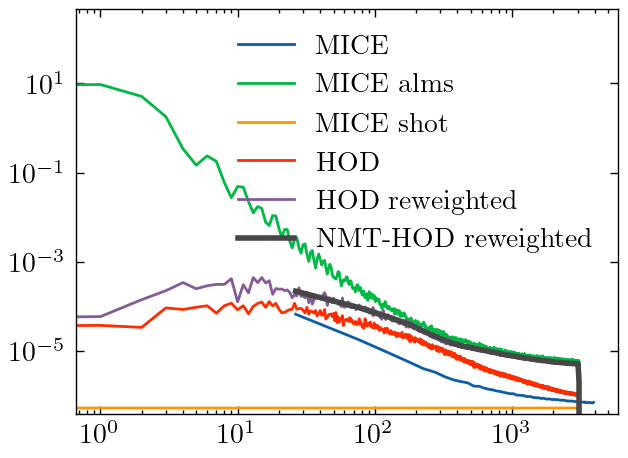

In [280]:
plt.loglog(ells, ggcounts, label = "MICE")

plt.loglog(ls, hp.alm2cl(alm_mice), label = "MICE alms")
plt.loglog(ls, np.ones_like(ls)/shot_noise_mice, label = "MICE shot")

plt.plot(ls, hp.alm2cl(alms), label = "HOD")
plt.plot(ls, hp.alm2cl(alm_counts), label = "HOD reweighted")

plt.plot(ells, np.dot(window_gg, hp.alm2cl(alm_counts)), label = "NMT-HOD reweighted", lw = 2)

plt.legend()
plt.ylim(4e-7)

(1e-09, 0.0012285620686499081)

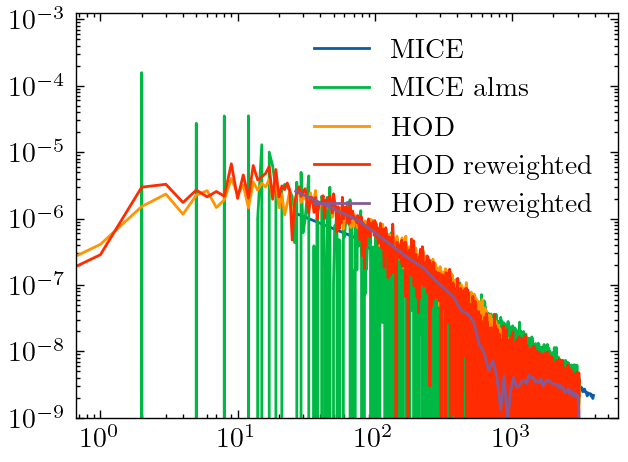

In [285]:
plt.loglog(ells, kgcounts, label = "MICE")

plt.loglog(ls, hp.alm2cl(alm_mice, kappa_mice_alm), label = "MICE alms")

plt.plot(ls, hp.alm2cl(alms, kappa_websky_alm), label = "HOD")
plt.plot(ls, hp.alm2cl(alm_counts, kappa_websky_alm), label = "HOD reweighted")

plt.plot(ells, np.dot(window_kg, hp.alm2cl(alm_counts, kappa_websky_alm)), label = "HOD reweighted")


plt.legend()
plt.ylim(1e-9)

(5e-07, 1.1061414037954833)

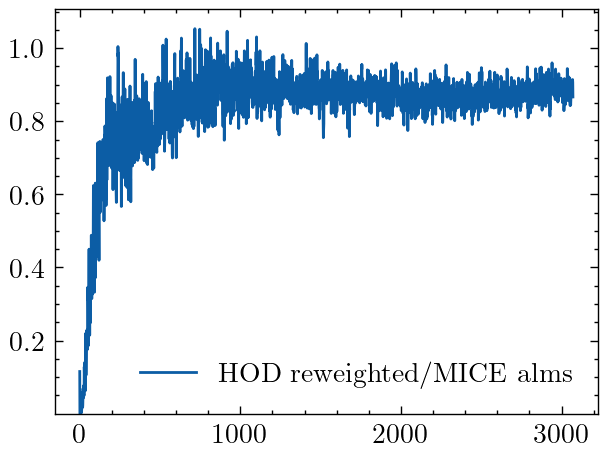

In [283]:
plt.plot(ls, hp.alm2cl(alm_counts)/hp.alm2cl(alm_mice), label = "HOD reweighted/MICE alms")

plt.legend()
plt.ylim(5e-7)

(50.0, 1100.0)

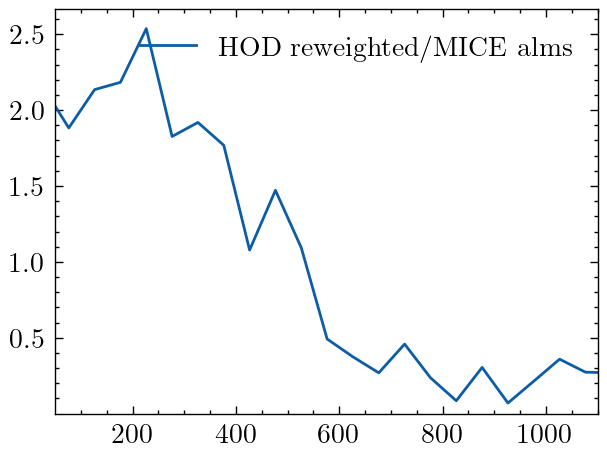

In [284]:
plt.plot(ells, np.dot(window_kg, hp.alm2cl(alm_counts, kappa_websky_alm))/kgcounts, label = "HOD reweighted/MICE alms")

plt.legend()
plt.ylim(5e-7)

plt.xlim(50, 1100)